# Nonparametric estimation with rabbits data

In [1]:
import requests
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss

# For inline pictures
%matplotlib inline
sns.set_context('notebook')
# For nicer output of Pandas dataframes
pd.set_option('float_format', '{:8.2f}'.format)
np.set_printoptions(precision = 3, suppress = True)

### Import the data

The data is available here: http://www.statsci.org/data/oz/rabbit.html

In [2]:
url = 'http://www.statsci.org/data/oz/rabbit.txt'
response = requests.get(url)
path = '../data/rabbit.txt'
with open(path, "wb") as file:
    file.write(response.content)
df = pd.read_csv('../data/rabbit.txt', sep='\t')
print(df.head())

   Age     Lens
0   15    21.66
1   15    22.75
2   15    22.30
3   18    31.25
4   28    44.79


### Plot the data

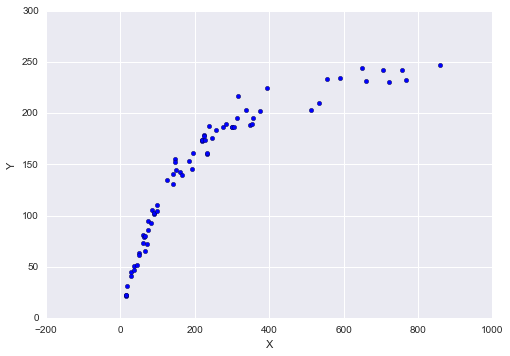

In [3]:
X, Y = np.array(df['Age']), np.array(df['Lens'])

plt.scatter(X, Y)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Estimate the density

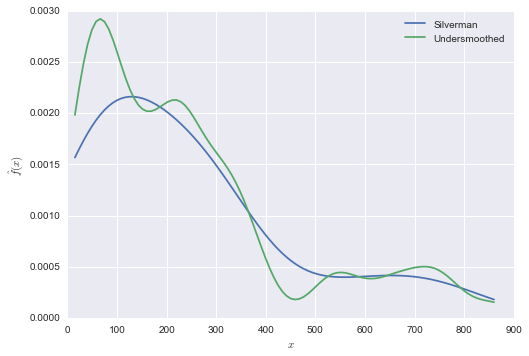

In [4]:
N = 100
U = np.linspace(X.min(), X.max(), N)
fxhat1 = ss.gaussian_kde(X, 'silverman')
fxhat2 = ss.gaussian_kde(X, .2)

plt.plot(U, fxhat1(U), label='Silverman')
plt.plot(U, fxhat2(U), label='Undersmoothed')
plt.xlabel('$x$')
plt.ylabel('$\hat{f}(x)$')
plt.legend()
plt.show()

### Kernels

Truncated (Uniform): $k_{0}\left(u\right)=\frac{1}{2}1\left(\left|u\right|\leq1\right)$

Epanechnikov: $k_{1}\left(u\right)=\frac{3}{4}\left(1-u^{2}\right)1\left(\left|u\right|\leq1\right)$

Biweight: $k_{2}\left(u\right)=\frac{15}{16}\left(1-u^{2}\right)^{2}1\left(\left|u\right|\leq1\right)$

Triweight: $k_{2}\left(u\right)=\frac{35}{36}\left(1-u^{2}\right)^{3}1\left(\left|u\right|\leq1\right)$

Gaussian: $k_{\phi}\left(u\right)=\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}u^2\right)$

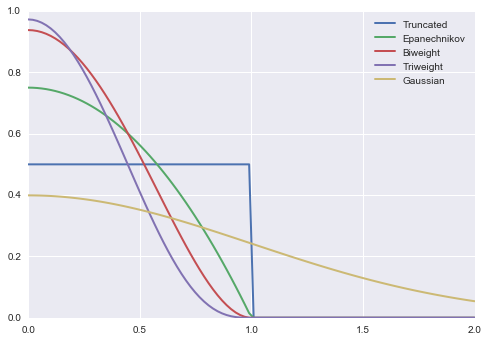

In [5]:
def indicator(x):
    return np.asfarray((np.abs(x) <= 1.) & (np.abs(x) >= 0.))

def kernel(x, ktype = 'Truncated'):
    if ktype == 'Truncated':
        return .5 * indicator(x)
    if ktype == 'Epanechnikov':
        return 3./4. * (1 - x**2) * indicator(x)
    if ktype == 'Biweight':
        return 15./16. * (1 - x**2)**2 * indicator(x)
    if ktype == 'Triweight':
        return 35./36. * (1 - x**2)**3 * indicator(x)
    if ktype == 'Gaussian':
        return 1./np.sqrt(2. * np.pi) * np.exp(- .5 * x**2)

def roughness(ktype = 'Truncated'):
    if ktype == 'Truncated':
        return 1./2.
    if ktype == 'Epanechnikov':
        return 3./5.
    if ktype == 'Biweight':
        return 5./7.
    if ktype == 'Triweight':
        return 350./429.
    if ktype == 'Gaussian':
        return np.pi**(-.5)/2.

def sigmak(ktype = 'Truncated'):
    if ktype == 'Truncated':
        return 1./3.
    if ktype == 'Epanechnikov':
        return 1./5.
    if ktype == 'Biweight':
        return 1./7.
    if ktype == 'Triweight':
        return 1./9.
    if ktype == 'Gaussian':
        return 1.

x = np.linspace(0., 2., 100)

names = ['Truncated', 'Epanechnikov', 'Biweight', 'Triweight', 'Gaussian']

for name in names:
    plt.plot(x, kernel(x, ktype = name), label = name, lw = 2)
plt.legend()
plt.show()

## Nadaraya-Watson (NW) or local constant estimator

$$\hat{m}\left(x\right)=\frac{\sum_{i=1}^{n}k\left(\frac{X_{i}-x}{h}\right)Y_{i}}{\sum_{i=1}^{n}k\left(\frac{X_{i}-x}{h}\right)}$$

For each observed data $X$ ($N$-vector) and grid $U$ ($M$-vector) this function returns $N\times M$-matrix of weights.

In [6]:
def weight(U, X, h=.1, ktype='Truncated'):
    # X - N-array
    # U - M-array
    
    # XmU - M*N-array
    XmU = (X - np.atleast_2d(U).T) / h
    # K - M*N-array
    K = kernel(XmU, ktype)
    
    # K.sum(1) - M-array
    # K.T - N*M-array
    # K.T / K.sum(1) - N*M-array
    return  (K.T / K.sum(1)).T

def NW(U, X, Y, h=.1, ktype='Truncated'):
    return np.dot(weight(U, X, h, ktype), Y)

## Local Linear (LL) estimator

$$\left(\begin{array}{c}
\hat{\alpha}\left(x\right)\\
\hat{\beta}\left(x\right)
\end{array}\right)=\left(\sum_{i=1}^{n}k_{i}\left(x\right)Z_{i}\left(x\right)Z_{i}\left(x\right)^{\prime}\right)^{-1}\sum_{i=1}^{n}k_{i}\left(x\right)Z_{i}\left(x\right)Y_{i}$$

$$\left(\begin{array}{c}
\hat{\alpha}\left(x\right)\\
\hat{\beta}\left(x\right)
\end{array}\right)
=\left(Z\left(x\right)^{\prime}K\left(x\right)Z\left(x\right)\right)^{-1}Z\left(x\right)^{\prime}K\left(x\right)Y$$

$K(x)$ - $N\times N$

$Z(x)$ - $N\times 2$

$Y$ - $N\times 1$

In [7]:
def LL(U, X, Y, h=.1, ktype='Truncated'):
    # X - N-array
    # U - M-array
    
    # K - M*N-array
    W = weight(U, X, h, ktype)
    alpha = np.empty(U.shape[0])
    beta = np.empty(U.shape[0])
    
    for i in range(U.shape[0]):
        # N*N-array
        K = np.diag(W[i])
        # N-array
        Z1 = (X - U[i]) / h
        Z0 = np.ones(Z1.shape)
        # 2*N-array
        Z = np.vstack([Z0, Z1]).T
        
        # 2*2-array
        A = np.dot(Z.T, np.dot(K, Z))
        # 2-array
        B = np.dot(Z.T, np.dot(K, Y))
        # 2-array
        coef = np.dot(np.linalg.inv(A), B)
        
        alpha[i] = coef[0]
        beta[i] = coef[1]
        
    return alpha, beta

## Estimate conditional expectation

In [8]:
N = 100
U = np.linspace(X.min(), X.max(), N)

h_silv = 1.06 * np.std(X) * N**(-1/5)
print('Silverman\'s Rule-of-Thumb =  %.2f' % h_silv)

# Nadaraya-Watson estimator
Yhat_NW = NW(U, X, Y, h=h_silv, ktype='Gaussian')
# Local Linear estimator
Yhat_LL, dYhat_LL = LL(U, X, Y, h=h_silv, ktype='Gaussian')

Silverman's Rule-of-Thumb =  88.99


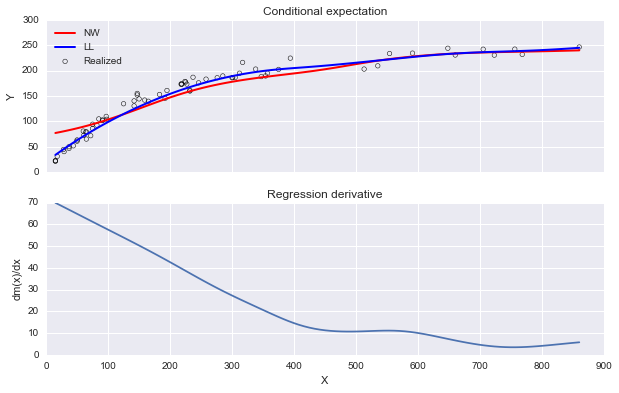

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

axes[0].plot(U, Yhat_NW, lw=2, color='red', label='NW')
axes[0].plot(U, Yhat_LL, lw=2, color='blue', label='LL')
axes[0].scatter(X, Y, s=20, lw=.5, facecolor='none', label='Realized')
axes[0].set_ylabel('Y')
axes[0].legend(loc='upper left')
axes[0].set_title('Conditional expectation')

axes[1].plot(U, dYhat_LL)
axes[1].set_title('Regression derivative')
axes[1].set_xlabel('X')
axes[1].set_ylabel('dm(x)/dx')

plt.show()

## Estimate conditional variance

### Leave-one-out errors

In [10]:
def error(Y, X, h, ktype):
    N = len(Y)
    ehat = np.empty(N)
    for i in range(N):
        ehat[i] = Y[i] - NW(X[i], np.delete(X, i), np.delete(Y, i), h=h, ktype=ktype)
    return ehat

### Use errors to estimate the variance

In [11]:
h = 30
ktype = 'Gaussian'

ehat = error(Y, X, h, ktype)

sigma2hat = NW(U, X, ehat**2, h=h, ktype=ktype)

fxhat = ss.gaussian_kde(X)(U)
V2hat = roughness(ktype) * sigma2hat / fxhat / N / h
shat_NW = V2hat**.5

### Plot the result

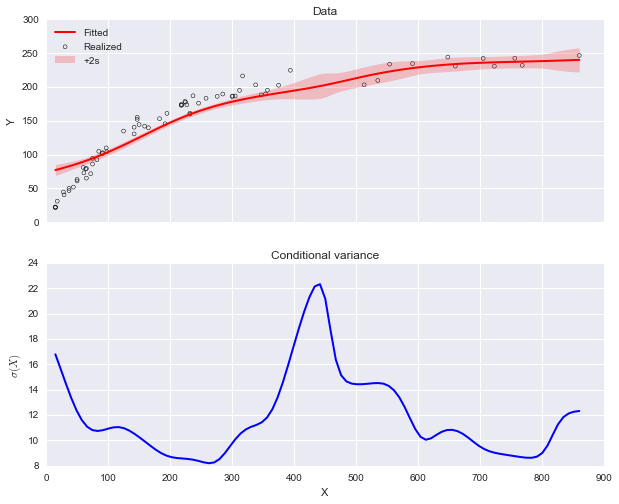

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].scatter(X, Y, s=15, lw=.5, facecolor='none', label='Realized')
axes[0].fill_between(U, Yhat_NW - 2*shat_NW, Yhat_NW + 2*shat_NW,
                     lw=0, color='red', alpha=.2, label='+2s')
axes[0].plot(U, Yhat_NW, lw=2, color='red', label='Fitted')
axes[0].set_ylabel('Y')
axes[0].legend(loc='best')
axes[0].set_title('Data')

axes[1].plot(U, sigma2hat**.5, lw=2, color='blue')
axes[1].set_xlabel('X')
axes[1].set_ylabel('$\sigma(X)$')
axes[1].set_title('Conditional variance')

plt.show()

## Bandwidth selection

### Cross-validation criterion

$$\tilde{e}_{i}\left(h\right)=Y_{i}-\tilde{m}_{-i}\left(X_{i},h\right)$$

$$CV\left(h\right)=\frac{1}{n}\sum_{i=1}^{n}\tilde{e}_{i}\left(h\right)^{2}$$

$$\hat{h}=\arg\min_{h\geq h_{l}}CV\left(h\right)$$

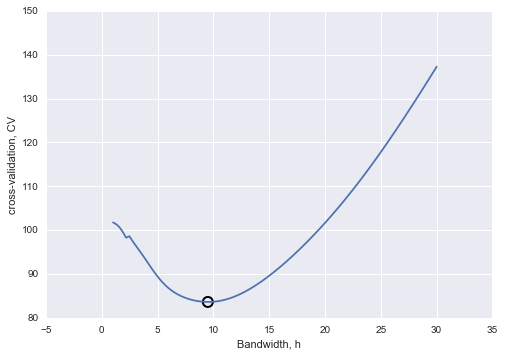

In [13]:
ktype = 'Gaussian'
H = np.linspace(1, 30, 100)
CV = np.array([])
for h in H:
    ehat = error(Y, X, h, ktype)
    CV = np.append(CV, np.nanmean(ehat**2))

h_CV = H[CV.argmin()]

plt.plot(H, CV)
plt.scatter(h_CV, CV.min(), facecolor='none', lw=2, s=100)
plt.xlabel('Bandwidth, h')
plt.ylabel('cross-validation, CV')
plt.show()